In [1]:
using LinearAlgebra, RowEchelon, Hadamard
using Random
using Latexify
using PyCall
itikz = pyimport("itikz")
nM    = pyimport("itikz.nicematrix")
jinja = pyimport("jinja2");

# 1.  Support Routines

## 1.1 Conversion to LaTeX for use by Itikz

In [96]:
# To use itikz (a python library, we need to convert our numerical result to TeX strings)
function to_latex_str(x)
    if x < 0  # fix up minus signs
        replace( "-"*latexify(-x), "\$"=>"")
    else
        replace( latexify(x), "\$"=>"")
    end
end
# ------------------------------------------------------------------------------
function to_latex_str(x::Complex{Int64})
    if imag(x) == 0
        return to_latex_str(real(x))
    end
    if real(x) < 0  # fix up minus signs
        replace( "-"*latexify(-x), "\$"=>"")
    else
        replace( latexify(x), "\$"=>"")
    end
end
# ------------------------------------------------------------------------------
function to_latex_str(x::Complex{Rational{Int64}})
    if imag(x) == 0
        return to_latex_str(real(x))
    end
    if real(x) < 0  # fix up minus signs
        replace( "-"*latexify(-x), "\$"=>"")
    else
        replace( latexify(x), "\$"=>"")
    end
end
# ------------------------------------------------------------------------------
function convert_to_latex(matrices)
    str_matrices = [[:none, to_latex_str.(matrices[1][2])]]
    for i in 2:size(matrices,1)
        push!( str_matrices, [ to_latex_str.(matrices[i][1]), to_latex_str.(matrices[i][2])] )
    end
    str_matrices
end;
# ------------------------------------------------------------------------------

## 1.2 Matrix Generation Routines

In [3]:
function factor_out_denominator( A::Array{Rational{Int64},2} )
    d = reduce( lcm, denominator.(A) )
    d, Int64.(d*A)
end;

### 1.2.1 Matrix Generation 

In [4]:
PythagoreanNumberTriplets =
[   3    4    5
    5   12   13
    7   24   25
    8   15   17
    9   40   41
   11   60   61
   12   35   37
   13   84   85
   15  112  113 ]

PythagoreanNumberQuadruplets =
[   1   2   2   3
    2  10  11  15
    4  13  16  21
    2  10  25  27
    2   3   6   7
    1  12  12  17
    8  11  16  21
    2  14  23  27
    1   4   8   9
    8  9   12  17
    3  6   22  23
    7  14  22  27
    4   4   7   9
    1   6  18  19
    3  14  18  23
   10  10  23  27
    2   6   9  11
    6   6  17  19
    6  13  18  23
    3  16  24  29
    6   6   7  11
    6  10  15  19
    9  12  20  25
   11  12  24  29
    3   4  12  13
    4   5  20  21
   12  15  16  25
   12  16  21  29
    2   5  14  15
    4   8  19  21
    2   7  26  27 ];

In [5]:
function unit_lower(m,n; maxint=3)
    # create a unit lower triangular matrix
    [ x>y ? rand(-maxint:maxint) : (x == y ? 1 : 0) for x in 1:m, y in 1:n]
end
function unit_lower(m; maxint=3)
   unit_lower(m,m,maxint=maxint)
end
function lower(m,n; maxint=3)
    L = unit_lower(m,n; maxint=maxint)
    for i in 1:min(m,n)
        L[i,i] = rand( [-maxint:-1; 1:maxint])
    end
    L
end

function lower(m; maxint=3)
    lower(m,m,maxint=maxint)
end

function rref_matrix(m,n,r; maxint=3, pivot_in_first_col=true, has_zeros=false)
    # create a reduced row echelon form matrix of size m x n and rank r
    pivot_indices = sort!(randperm(n)[1:r])
    if pivot_in_first_col
        pivot_indices[1]= 1
    end
    if has_zeros
        rng = -mxint:maxint
    else
        rng = [-maxint:-1; 1:maxint]
    end

    if m > r
        M = [ rand(rng, (r,n))
              zeros(Int64, (m-r,n))
        ]
    else
        M = rand( rng, (m,n) )
    end
    for i in 1:r
        for j in 1:(pivot_indices[i]-1)
            M[i,j] = 0
        end
        M[i,pivot_indices[i]]         = 1
        M[1:(i-1), pivot_indices[i]] .= 0
    end
    M, pivot_indices
end
# ------------------------------------------------------------------------------
function symmetric_matrix(m;maxint=3, with_zeros=false )
    if with_zeros
        rng = -mxint:maxint
    else
        rng = [-maxint:-1; 1:maxint]
    end
    A = [ x>y ? rand(rng) : 0 for x in 1:m, y in 1:m]
    A = A+A'
    for i in 1:m
        A[i,i] = rand([-maxint:-1; 1:maxint])
    end
    A
end
# ------------------------------------------------------------------------------
function skew_symmetric_matrix(m;maxint=3, with_zeros=false )
    if with_zeros
        rng = -mxint:maxint
    else
        rng = [-maxint:-1; 1:maxint]
    end
    A = [ i>j ? rand(rng) : 0 for i in 1:m, j in 1:m]
    A - A'
end
# ------------------------------------------------------------------------------
function onecol(m,c; maxint=3)
    # take I and set column c to random entries
    E        = collect(1I(m))           # Int64  eye(m)
    E[1:m,c] = rand(-maxint:maxint, m)  # set column c to non-zero entries
    E[c,c]   = 1
    E
end
# ------------------------------------------------------------------------------
function W_2_matrix(;maxint=3)
    a,b,c = PythagoreanNumberTriplets[ rand(1:size(PythagoreanNumberTriplets,1)), : ]
    c,[ a -b; b a]
end
function Q_2_matrix(;maxint=3)
    c,W = W_2_matrix(maxint=maxint)
    W // c
end    
# ------------------------------------------------------------------------------
function W_3_matrix(;maxint=3)
    a,b,c = PythagoreanNumberTriplets[ rand(1:size(PythagoreanNumberTriplets,1)), : ]
    A = [ a -b 0
          b  a 0
          0  0 rand( [-maxint:-1; 1:maxint]) ]
    A = A[shuffle(1:3),:]
    c,A[ :, shuffle(1:3)]
end
# ------------------------------------------------------------------------------
function Q_3_matrix(;maxint=3)
    a,b,c = PythagoreanNumberTriplets[ rand(1:size(PythagoreanNumberTriplets,1)), : ]
    A = [ a//c -b//c  0
          b//c  a//c  0
             0     0  1 ]
    A = A[shuffle(1:3),:]
    A[ :, shuffle(1:3)]
end

# the following matrix has a block structure
function Q_4_blocks(;maxint=3)
    a1,b1,c1 = PythagoreanNumberTriplets[ rand(1:size(PythagoreanNumberTriplets,1)), : ]
    a2,b2,c2 = PythagoreanNumberTriplets[ rand(1:size(PythagoreanNumberTriplets,1)), : ]

    A = [ a1//c1 -b1//c1             0            0
          b1//c1  a1//c1             0            0
          0                          0   a2//c2  b2//c2 
          0                          0  -b2//c2  a2//c2 ]
    A = A[shuffle(1:4), :]
    A[ :, shuffle(1:4)]
end

function W_4_matrix(;maxint=3)
    a,b,c,d = PythagoreanNumberQuadruplets[ rand(1:size(PythagoreanNumberQuadruplets,1)), : ]
    p  = (a*a + b*b) * d*d
    a2 = -a*c* p
    a3 =  a*b* p
    a4 =  a*a* p

    den = gcd(gcd( a2, a3), a4 )
    a2 = Int64( a2 // den)
    a3 = Int64( a3 // den)
    a4 = Int64( a4 // den)

    A = [ a -b -c   0
          b  a  0  a2
          c  0  a  a3 
          0  c -b  a4 ]
    A = A
    A = A[shuffle(1:4), :]
    d,A[ :, shuffle(1:4)]
end

function Q_4_matrix(;maxint=3)
    d,W = W_4_matrix(maxint=maxint)
    W//d
end

function Q_matrix(n; maxint=3)
    if     n == 2 return Q_2_matrix(maxint=maxint)
    elseif n == 3 return Q_3_matrix(maxint=maxint)
    end
    S=skew_symmetric_matrix(n)
    A=inv(S-(1//1)I(size(S,1))) * (S+1I(size(S,1)))
end

function sparse_Q_matrix(n; maxint=3)
    sz = sum(n)
    A  = zeros(Rational{Int64},(sz,sz))
    i  = 1
    for m in n
        S = Rational{Int64}.( skew_symmetric_matrix(m) )
        E = (1//1)I(m)
        F = inv( S - E ) * ( S + E )
        rng = i:i+m-1 |> collect
        A[rng,rng] = F
        i += m
    end

    A = A[shuffle(1:sz), :]
    A[ :, shuffle(1:sz)]
end

function sparse_W(n; maxint=3)
    A = sparse_Q_matrix(n,maxint=maxint)
    factor_out_denominator(A)
end
;

### 1.2.2 Matrix Computation

In [6]:
function particular_solution( pivot_indices, n; maxint=3 )
    # given the pivot locations, generate a particular solution of N entries
    x                = zeros(Int64, (n,1))
    x[pivot_indices] = rand( [-maxint:-1; 1:maxint], (length(pivot_indices),1) )
    x
end

function eform(m,n; maxint=3, one_in_n=4, kill_a_row = 0)
    # create a row echelon form and a particular solution
    #     one_in_n chances of a pivot
    # TODO: fix for GJ; currently resulting in fractions  use gj_problem instead!!!
    sel = reshape( [-maxint:-1; 1:maxint], 2*maxint)
    U   = rand( sel, m,n)
    if kill_a_row > 0
        U[kill_a_row,1:n] .= 0
    end
    x = rand( sel, n)

    first = 1
    for i in 2:m
        have_p = rand( [Base.repeat([0], one_in_n-1); 1]) # whether this location has a pivot
        if have_p == 0 first = first+1 end
        first = min( first, n)
        x[first] = x[first]*have_p
        for j in 1:first U[i,j] = 0 end
        first = first+1
    end
    for j in (first+1):n x[j] = 0 end
    #
    U,x
end
# ------------------------------------------------------------------------------
function gen_matrix(m,n; maxint=3, one_in_n=4)
    # create a GE problem of size MxN
    e   = unit_lower(m,m,maxint=maxint)
    u,x = eform(m,n,maxint=maxint,one_in_n=one_in_n)
    A   = Rational{Int64}.(e*u)
end
# ------------------------------------------------------------------------------
function ge_pb(m,n; maxint=3, one_in_n=4)
    # create a GE problem of size MxN, righthand side b and particular solution x
    e   = unit_lower(m,m,maxint=maxint)
    u,x = eform(m,n,maxint=maxint,one_in_n=one_in_n)
    A   = e*u
    b   = A*x
    A,x,b
end
# ------------------------------------------------------------------------------
function gj_problem(m,n,r; maxint=3, pivot_in_first_col=true)
    M,pivot_indices=rref_matrix(m,n,r,maxint=maxint,pivot_in_first_col=pivot_in_first_col)
    i = 1
    for j in pivot_indices
        M[i,j] = rand([-maxint:-1; 1:maxint])
        M[i,j+1:end] *= M[i,j]
        i += 1
    end

    A = unit_lower(m,maxint=maxint) * unit_lower(m,maxint=maxint)' * M
    x                = zeros(Int64, (n,1))
    x[pivot_indices] = rand( [-maxint:-1; 1:maxint], (r,1) )
    b = A*x
    A,x,b
end

function gj_problem(m,n; maxint=3, pivot_in_first_col=true)
    A,x,b = gj_problem(m,n,min(m,n), maxint=maxint, pivot_in_first_col=pivot_in_first_col)
end

function homogeneous_solutions( R, pivot_indices)
    # homogeneous solution from a reduced row echelon form R
    r = length(pivot_indices)                                                 # rank
    c = findall( j->j==1, [i in pivot_indices ? 0 : 1 for i in 1:size(R,2)] ) # free variable columns
    H = zeros(Int64, (size(R,2),length(c)))                                   # matrix of homogeneous solutions
    for j in eachindex( c )                                                   # homogeneous solution vector x_j
        H[c[j],j] = 1                                                         # set the current free variable entry to 1
        H[pivot_indices,j] = -R[1:r, c[j]]                                    # set the pivot variable values
    end
    H
end

# ------------------------------------------------------------------------------
function inv_pb(n; maxint=3)
    # create an invertible matix problem of size n x n
    e1 = unit_lower( n,n, maxint=maxint )
    e2 = unit_lower( n,n, maxint=maxint )
    A  = e1*e2'

    A_inv = inv(A)
    A, Int64.(round.(A_inv))
end
# ------------------------------------------------------------------------------
function print_np_array_def(A)
    M,N=size(A)
    println("A = np.array([")
    for i in 1:M
        print("[")
        for j in 1:(N-1)
            print(" ", A[i,j], ",")
        end
        println(" ", A[i, N], "],")
    end
    println("])")
end;

In [7]:
function plu_pb( m,n; maxint=3, one_in_n=4, kill_a_row=0)
    # create a GE problem of size MxN, righthand side b and particular solution x
    # TODO: if the last row happens to be zero, this may not work!
    e   = unit_lower(m,m,maxint=maxint)
    if kill_a_row==0
        u,x = eform(m,n,maxint=maxint,one_in_n=one_in_n)
    else
        u,x = eform(m,n,maxint=maxint,one_in_n=one_in_n, kill_a_row=rand(2:m-1))
    end
    A   = e*u
    b   = A*x
    A,x,b
end;

## 1.3 GE, GJ and QR Algorithms

### 1.3.1 Gaussian Elimination Routine

In [72]:
function find_pivot(A, row, col)
    for i in row:size(A,1)
        if A[i,col] != 0  return i end
    end
    -1
end
function non_zero_entry( A, row, col, gj )
    set = (row+1):size(A,1)
    if gj && row > 1
        set = [1:row-1; set]
    end
    for i in set
        if  A[i,col] != 0 return true end
    end
    false
end
function interchange(A, row_1, row_2)
    for j in 1:size(A,2)
        A[row_1,j],A[row_2,j] = A[row_2,j],A[row_1,j]
    end
end
function eliminate( A, pivot_row, row, alpha)
    for j in 1:size(A,2)
        A[row,j] += alpha * A[pivot_row,j]
    end
end

function e_ref(A; gj=false)
    matrices       = [[ :none, A ]]
    pivot_indices  = []
    if eltype(A) == Complex{Int64}
        A = Complex{Rational{Int64}}.(copy(A))
    elseif eltype(A) == Int64
        A = Rational{Int64}.(copy(A))
    else
        A = copy(A)  # caller took care of the type
    end

    M,N            = size(A)
    row = 1; col = 1
    while true
        if (row > M) || (col > N)
            if gj && M > 0                            # Scaling Matrix; only needed if there is a pivot != 1
                require_scaling = false

                E = Matrix{eltype(A)}(I, M, M)
                for i in 1:size(pivot_indices,1)
                    if isone( A[i,pivot_indices[i]] ) == false
                        require_scaling = true
                    end

                    E[i,i] = 1 // A[i,pivot_indices[i]] 
                end
                if require_scaling
                    push!(matrices, [E, E*A])
                end
            end
            return matrices, pivot_indices
        end

        p = find_pivot(A, row, col)
        if p < 0
            col += 1
        else
            push!(pivot_indices, col)
            if p != row
                interchange( A, p, row )
                E = Matrix{eltype(A)}( I, M, M)
                interchange( E, p, row )
                push!(matrices, [E, copy(A)])
            end

            if non_zero_entry( A, row, col, gj )
                E = Matrix{eltype(A)}(I, M, M)

                for r in (row+1):M
                    alpha = -A[r,col] / A[row,col]
                    eliminate(A, row, r, alpha )
                    eliminate(E, row, r, alpha )
                end

                if gj
                    for r in 1:(row-1)
                        alpha = -A[r,col] / A[row,col]
                        eliminate(A, row, r, alpha )
                        eliminate(E, row, r, alpha )
                    end
                end

                push!(matrices, [E, copy(A)])
            end
            col += 1; row += 1
        end
    end
    matrices, pivot_indices
end;

### 1.3.2 QR Routine

In [9]:
"""Naive Gram-Schmidt"""
function gram_schmidt_w(A)
    W   = Array{Rational{eltype(A)}}(undef, size(A))
    M,N = size(A)
    for j=1:N
        v_j = Rational.(A[:,j])
        for k=1:j-1
            v_j = v_j - (dot(W[:,k], A[:,j]) / dot(W[:,k], W[:,k]) ) .* W[:,k]
        end
        tmp = reduce( (x,y)-> lcm(x,denominator(y)), v_j, init=1) * v_j
        d   = reduce( gcd, tmp, init=tmp[1] )
        W[:,j] =  tmp / d
    end
    Int64.(W)
end

function qr_layout(A)
    W = gram_schmidt_w(A)

    WtW  = Diagonal(W'W)
    WtA  = W'A
    S    =  ((x-> Rational{Int64}(round(sqrt(x)))).(WtW))^(-1)

    Qt = S * W'
    R  = S * WtA

    matrices =  [ [ :none,  :none,     A,        W ],
                  [ :none,     W',   WtA,      WtW ],
                  [     S,     Qt,     R,    :none ] ]

    convert_to_latex( matrices )
end;

# 2. GE Problems

## 2.1 GE Problem with Layout

In [10]:
A,x,b = ge_pb(3,5)
display("*************************** A ="); display(A)
display("*************************** b ="); display(b)
display("*************************** x ="); display(x)
print_np_array_def( [A b])

"*************************** A ="

3×5 Matrix{Int64}:
 -3  2  -2   2  -2
 -3  4  -5   0   1
  3  2  -4  -5  10

"*************************** b ="

3-element Vector{Int64}:
 3
 3
 0

"*************************** x ="

5-element Vector{Int64}:
 3
 3
 0
 3
 0

A = np.array([
[ -3, 2, -2, 2, -2, 3],
[ -3, 4, -5, 0, 1, 3],
[ 3, 2, -4, -5, 10, 0],
])


Matrix type information:Matrix{Rational{Int64}}
Particular Solution: [-3, 0, 3, 0, -1, 0]



Reverting Windows console CPs to (in,out) = (437,437)


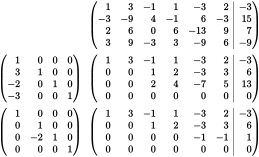

In [73]:
A,x,b = ge_pb( 4,6, maxint=3, one_in_n=4 )
matrices, pivot_indices = e_ref(Rational{Int64}.([A b]), gj=false)
println("Matrix type information:", typeof(matrices[1][2]))
println("Particular Solution: ", x)
println()
h,m=nM.ge(convert_to_latex(matrices), formater=x->x, Nrhs=1)
h

Particular Solution: [-1, 0, 2, 0, 2, 0]



Reverting Windows console CPs to (in,out) = (437,437)


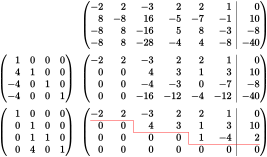

In [74]:
A,x,b = ge_pb( 4,6, maxint=4, one_in_n=4 )
matrices, pivot_indices = e_ref(Rational{Int64}.([A b]), gj=false)
#println("Matrix type information:", typeof(matrices[1][2]))
println("Particular Solution: ", x)
println()

pivot_locs = [(i-1,Int64(pivot_indices[i]-1)) for i in eachindex(pivot_indices)]

h,m = nM.ge(convert_to_latex(matrices), formater=x->x, Nrhs=1,
           ref_path_list =  [ [length(matrices)-1, 1, pivot_locs, "hh","red"] ])
h

Particular Solution: [-4; 0; -3; 3;;]
pivot list:          [1, 3, 4]



"Homogeneous Solutions: "

4×1 Matrix{Int64}:
 -4
  1
  0
  0

Reverting Windows console CPs to (in,out) = (437,437)


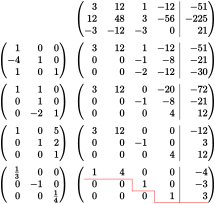

In [75]:
A,x,b=gj_problem(3,4,3, maxint=4 )
matrices, pivot_indices = e_ref(Rational{Int64}.([A b]), gj=true)

println("Particular Solution: ", x)
println("pivot list:          ", Int64.(pivot_indices) )
println()
# -------------------------------------------------------------------
R = matrices[length(matrices)][2]
R=R[:,1:size(A,2)]

H = homogeneous_solutions( R, pivot_indices )
display("Homogeneous Solutions: "); display(H)
println()
# -------------------------------------------------------------------
pivot_locs = [(i-1,Int64(pivot_indices[i]-1)) for i in eachindex(pivot_indices)]

h,m=nM.ge( convert_to_latex(matrices), formater=x->x, Nrhs=1,
           ref_path_list =  [ [length(matrices)-1, 1, pivot_locs, "hh","red"] ]
)
h

Reverting Windows console CPs to (in,out) = (437,437)


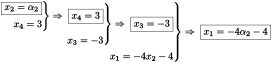

In [76]:
cascade = nM.BacksubstitutionCascade.from_ref_Ab(Int.(matrices[end][2] ))
cascade.show()

In [77]:
R = matrices[length(matrices)][2]
R=R[:,1:size(A,2)]

println( "Homogeneous Solutions")
H = homogeneous_solutions( R, pivot_indices )

Homogeneous Solutions


4×1 Matrix{Int64}:
 -4
  1
  0
  0

Particular Solution: [3; 3; 1; -1;;]
pivot list:          [1, 2, 3, 4]



"Homogeneous Solutions: "

4×0 Matrix{Int64}

Reverting Windows console CPs to (in,out) = (437,437)


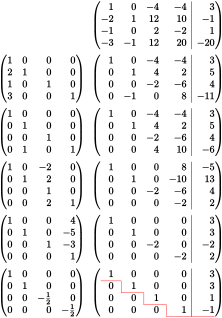

In [78]:
A,x,b=gj_problem(4,4,4, maxint=3)
matrices, pivot_indices = e_ref(Rational{Int64}.([A b]), gj=true)

println("Particular Solution: ", x)
println("pivot list:          ", Int64.(pivot_indices) )
println()
# -------------------------------------------------------------------
R = matrices[length(matrices)][2]
R=R[:,1:size(A,2)]

H = homogeneous_solutions( R, pivot_indices )
display("Homogeneous Solutions: "); display(H)
println()
# -------------------------------------------------------------------
pivot_locs = [(i-1,Int64(pivot_indices[i]-1)) for i in eachindex(pivot_indices)]

h,m=nM.ge( convert_to_latex(matrices), formater=x->x, Nrhs=1,
           ref_path_list =  [ [length(matrices)-1, 1, pivot_locs, "hh","red"] ]
)
h

### 2.1.1 Example

Reverting Windows console CPs to (in,out) = (437,437)


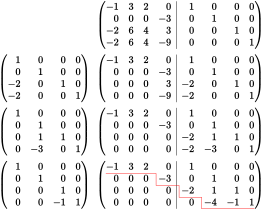

In [79]:
A,x,b = gj_problem( 4,4,2, maxint=3 )
matrices, pivot_indices = e_ref(Rational{Int64}.([A 1I]), gj=false)

pivot_locs = [(i-1,Int64(pivot_indices[i]-1)) for i in eachindex(pivot_indices)]

h,m = nM.ge(convert_to_latex(matrices), formater=x->x, Nrhs=size(A,1),
           ref_path_list =  [ [length(matrices)-1, 1, pivot_locs, "hh","red"] ])
h

Particular Solution: [-3; 0; 0; -1;;]



"Homogeneous Solutions: "

4×2 Matrix{Int64}:
 1  1
 1  0
 0  1
 0  0

Reverting Windows console CPs to (in,out) = (437,437)


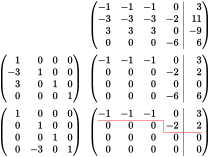

In [81]:
A,x,b = gj_problem( 4,4,2, maxint=3 )
#b=0*b
matrices, pivot_indices = e_ref(Rational{Int64}.([A b]), gj=false)
#println("Matrix type information:", typeof(matrices[1][2]))
println("Particular Solution: ", x)
println()
R = matrices[length(matrices)][2]
R = R[:,1:size(A,2)]
#display(Int64.(R))
H = homogeneous_solutions( R, pivot_indices )
display("Homogeneous Solutions: "); display(H)
println()

pivot_locs = [(i-1,Int64(pivot_indices[i]-1)) for i in eachindex(pivot_indices)]

h,m = nM.ge(convert_to_latex(matrices), formater=x->x, Nrhs=1,
           ref_path_list =  [ [length(matrices)-1, 1, pivot_locs, "hh","red"] ])
h

Reverting Windows console CPs to (in,out) = (437,437)


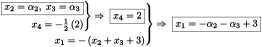

In [82]:
cascade = nM.BacksubstitutionCascade.from_ref_Ab(Int.(matrices[end][2] ))
cascade.show()

Particular Solution: [-3; 0; 0; -1;;]



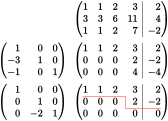

In [83]:
A=[1 1 2 3; 3 3 6 11; 1 1 2 7]
b=[2;4;-2]
matrices, pivot_indices = e_ref(Rational{Int64}.([A b]), gj=false)
println("Particular Solution: ", x)
println()

pivot_locs = [(i-1,Int64(pivot_indices[i]-1)) for i in eachindex(pivot_indices)]

h,m = nM.ge(convert_to_latex(matrices), formater=x->x, Nrhs=1,
           ref_path_list =  [ [length(matrices)-1, 1, pivot_locs, "hh","red"] ])
h

Reverting Windows console CPs to (in,out) = (437,437)


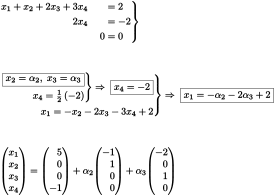

In [84]:
cascade = nM.BacksubstitutionCascade.from_ref_Ab(Int.(matrices[end][2] ))
cascade.show(show_system=true, show_cascade=true, show_solution=true)

In [85]:
R = matrices[length(matrices)][2]
R=R[:,1:size(A,2)]

println( "Homogeneous Solutions")
H = homogeneous_solutions( R, pivot_indices )

Homogeneous Solutions


4×2 Matrix{Int64}:
 -1  -2
  1   0
  0   1
  0   0

## 2.2 Inverse Problem with Layout

In [23]:
A, A_inv = inv_pb(3, maxint=4)
display("A ="); display(A)
display("A.inv ="); display(A_inv)

print_np_array_def([A I(size(A)[1]) ])

"A ="

3×3 Matrix{Int64}:
  1   1   2
 -2  -1  -6
 -2   0  -7

"A.inv ="

3×3 Matrix{Int64}:
  7   7  -4
 -2  -3   2
 -2  -2   1

A = np.array([
[ 1, 1, 2, 1, 0, 0],
[ -2, -1, -6, 0, 1, 0],
[ -2, 0, -7, 0, 0, 1],
])


Reverting Windows console CPs to (in,out) = (437,437)


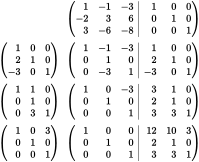

In [86]:
A, A_inv               = inv_pb(3, maxint=3)
matrices,pivot_indices = e_ref(Rational{Int64}.([A 1I]), gj=true)
h,m=nM.ge( convert_to_latex(matrices), formater=x->x, Nrhs=size(A,1) )
h

Reverting Windows console CPs to (in,out) = (437,437)


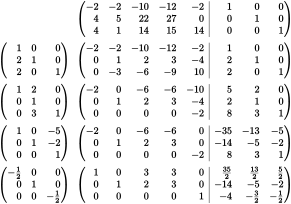

In [87]:
A=gj_problem(3,5)[1]
matrices,pivot_indices = e_ref(Rational{Int64}.([A 1I]), gj=true)
h,m=nM.ge( convert_to_latex(matrices), formater=x->x, Nrhs=size(A,1) )
h

In [88]:
println("E inverse contain the pivot cols in the first 1:rank columns")
display(Int64.(inv((matrices[end][2])[:,end-2:end]))) #*matrices[end][2][:,1:5])
println("it also contains the switching matrix in its rows:")
display(Int64.(inv((matrices[end][2])[:,end-2:end]) *matrices[end][2][:,1:5]))
println("We can factor it out of E and obtain C M R")

E inverse contain the pivot cols in the first 1:rank columns


3×3 Matrix{Int64}:
 -2  -2  -2
  4   5   0
  4   1  14

it also contains the switching matrix in its rows:


3×5 Matrix{Int64}:
 -2  -2  -10  -12  -2
  4   5   22   27   0
  4   1   14   15  14

We can factor it out of E and obtain C M R


## 2.3 PLU Problem

Reverting Windows console CPs to (in,out) = (437,437)


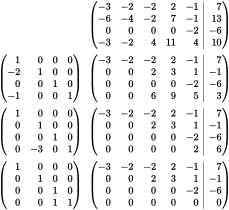

In [89]:
A,x,b=plu_pb(4,5, maxint=3, kill_a_row=0)
matrices,pivot_indices = e_ref([A b])
h,m=nM.ge(convert_to_latex(matrices), formater=x->x, Nrhs=1 )
h

# 3 Normal Equation Problems

<strong style="color:red;">needs work...</strong>

## 3.1 Solve the Normal Equation

In [28]:
function normal_equation_matrix(m,n; maxint=3)
    Q = sparse_Q_matrix(m,maxint=maxint)
    m = sum(m)
    n = sum(n)
    M = zeros(Int64, (m,n))
    for i = 1:min(m,n)
        M[i,i] = rand( [-maxint:-1; 1:maxint])
    end
    Q[:,1:m]*unit_lower(m,maxint=maxint)*M
end
# =======================================================================================
A=normal_equation_matrix((3,2),2; maxint=1)
d,intA = factor_out_denominator(A)
println( "A = ", 1//d, " [");
for i in 1:size(A,1)
    for j in 1:size(A,2)
        print("\t", intA[i,j] )
    end
    println()
end
println("]")

display("A'A"); display(Int64.(A'A)); display("det(A'A) "); display( Int64.(det(A'A)))

A = 1//15 [
	0	12
	2	9
	0	-9
	-10	15
	-11	-12
]


"A'A"

2×2 Matrix{Int64}:
 1  0
 0  3

"det(A'A) "

3

In [29]:
function ca_projection_matrix(A)
    A*inv(A'A)*A'
end
P=ca_projection_matrix( gen_matrix(3,1;one_in_n=1))
d,intP = factor_out_denominator(P)
display( 1//d);display(intP);

1//5

3×3 Matrix{Int64}:
 1  2  0
 2  4  0
 0  0  0

In [30]:
P=ca_projection_matrix( gen_matrix(3,3;one_in_n=1))
d,intP = factor_out_denominator(P)
display( 1//d);display(intP);

1//1

3×3 Matrix{Int64}:
 1  0  0
 0  1  0
 0  0  1

# 4. QR Problems

## 4.1 Orthogonal Matrices

In [31]:
function qr_problem(even_n;maxint=3)
    hadamard(even_n)[:,shuffle(1:even_n)]*lower(even_n,maxint=maxint)'
end

function qr_problem_3(;maxint=3)
    d,W = W_3_matrix(maxint=maxint)
    W*unit_lower(3, maxint=maxint)'
end

function qr_problem_4(;maxint=3)
    d,W = W_4_matrix(maxint=maxint)
    W*unit_lower(4,maxint=maxint)'
end
;

In [32]:
S = Q_matrix(4)
d,intS = factor_out_denominator(S)
display( 1//d);display(intS);

Int64.(S'S)

1//15

4×4 Matrix{Int64}:
  0  -10  10   5
  0   11  10   2
  0    2  -5  14
 15    0   0   0

4×4 Matrix{Int64}:
 1  0  0  0
 0  1  0  0
 0  0  1  0
 0  0  0  1

## 4.2 QR

Reverting Windows console CPs to (in,out) = (437,437)


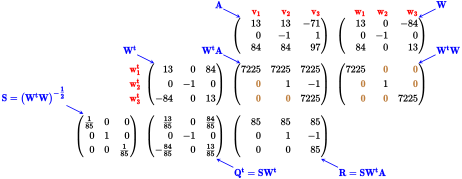

In [33]:
A   = qr_problem_3(maxint=1)
W   = gram_schmidt_w(A)
h,m = nM.gram_schmidt_qr(A, W)
h

Reverting Windows console CPs to (in,out) = (437,437)


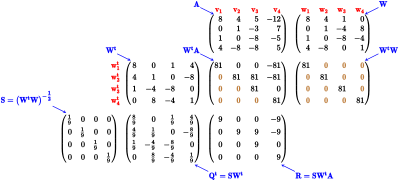

In [34]:
A   = qr_problem_4(maxint=1)
W   = gram_schmidt_w(A)
h,m = nM.gram_schmidt_qr(A, W, fig_scale=0.8)
h

Reverting Windows console CPs to (in,out) = (437,437)


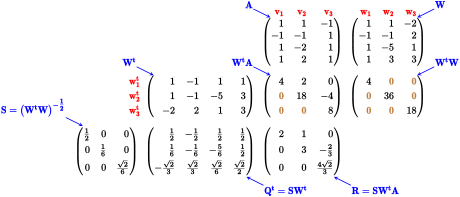

In [35]:
A=[ 1  1 -1
   -1 -1  1
    1 -2  1
    1  2  1
]
W   = gram_schmidt_w(A)
h,m = nM.gram_schmidt_qr(A, W)
h

Reverting Windows console CPs to (in,out) = (437,437)


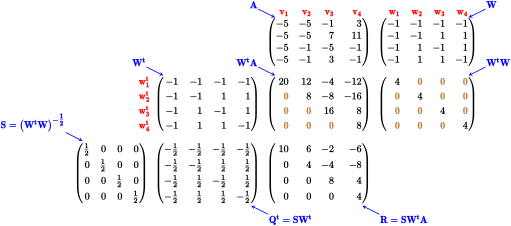

In [36]:
A   = qr_problem(4, maxint=5) #[:,shuffle(2:4)]
W   = gram_schmidt_w(A)
h,m = nM.gram_schmidt_qr(A, W)
h

# 5. Eigenproblems

In [37]:
function eigenproblem( e_vals; maxint=3 )
    Λ = Diagonal( e_vals )
    S,S_inv = inv_pb( size(e_vals,1), maxint=maxint )
    S*Λ*S_inv
end
function symmetric_eigenproblem( e_vals; maxint=3 )
    S = Q_matrix( size(e_vals,1), maxint=maxint )
    S * Diagonal( e_vals ) * S'
end
function non_diagonalizable_eigenproblem( e_dup, e; maxint=4 )
    # size 3x3 problem
    S,S_inv = inv_pb(3, maxint=maxint )
    Λ = [e_dup 1 0; 0 e_dup 0; 0 0 e]
    S * Λ * S_inv
end

function svd_problem(m,n,σ; maxint = 3)
    U  = sparse_Q_matrix( m, maxint=maxint)
    Vt = sparse_Q_matrix( n, maxint=maxint)
    m = sum(m); n=sum(n)
    Σ  = zeros(eltype(σ[1]), m,n)
    for i in 1:min( m, size(σ,1) )
        Σ[i,i] = σ[i]
    end
    U * Σ * Vt
end
;

3×3 Matrix{Int64}:
  7   9   3
 -4  -5  -2
  2   3   2

Reverting Windows console CPs to (in,out) = (437,437)


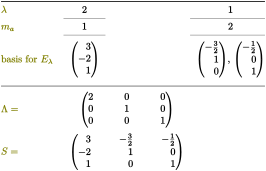

In [38]:
A=eigenproblem([1,1,2])
display(A)
nM.show_eig_tbl(A,fig_scale=1, mmLambda=11, color="Olive")

In [39]:
A=symmetric_eigenproblem([1,1,0], maxint=2)

3×3 Matrix{Rational{Int64}}:
  64//289  0//1  120//289
   0//1    1//1    0//1
 120//289  0//1  225//289

1//289

3×3 Matrix{Int64}:
  64    0  120
   0  289    0
 120    0  225

Reverting Windows console CPs to (in,out) = (437,437)


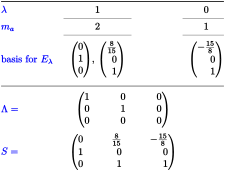

In [40]:
d,A_=factor_out_denominator(A)
display(1//d); display(A_)
nM.show_eig_tbl(A_,Ascale=d,fig_scale=1, mmLambda=11, color="blue")

In [41]:
A=non_diagonalizable_eigenproblem(2,0)

3×3 Matrix{Int64}:
  4   19  -9
 -4  -32  16
 -8  -64  32

Reverting Windows console CPs to (in,out) = (437,437)


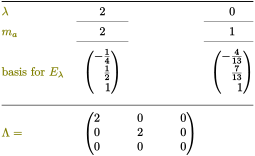

In [42]:
nM.show_eig_tbl(A,fig_scale=1.2, mmLambda=11, color="Olive")

In [43]:
A=svd_problem( 3,[3,2],  [2,2],  maxint=2)
d,intA=factor_out_denominator(A)
display(1//d);display(d*d);display(intA)

1//45

2025

3×5 Matrix{Int64}:
  40   32  0  0  -24
  10  -64  0  0   48
 -80    8  0  0   -6

Reverting Windows console CPs to (in,out) = (437,437)


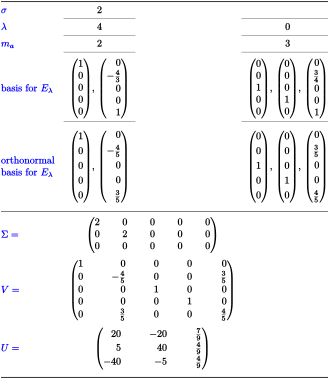

In [44]:
nM.show_svd_table(intA, Ascale=d)

Reverting Windows console CPs to (in,out) = (437,437)


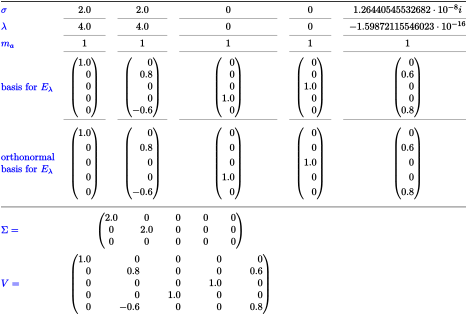

In [45]:
nM.show_svd_table(A)

In [46]:
#A=svd_problem(4,[2,3],[2,1,1])
sol=svd(intA)
display("U =");display(round.(sol.U, digits=3))
display("singular values =");display(round.(sol.S, digits=3))
display("Vt =");display(round.(sol.Vt, digits=3))

"U ="

3×3 Matrix{Float64}:
 -0.629   0.0    0.778
  0.55   -0.707  0.444
  0.55    0.707  0.444

"singular values ="

3-element Vector{Float64}:
 90.0
 90.0
  0.0

"Vt ="

3×5 Matrix{Float64}:
 -0.707  -0.566  0.0  0.0   0.424
 -0.707   0.566  0.0  0.0  -0.424
 -0.0    -0.6    0.0  0.0  -0.8

Reverting Windows console CPs to (in,out) = (437,437)


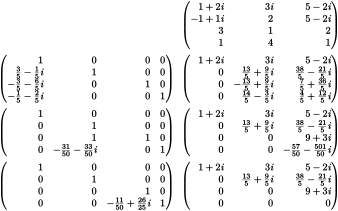

In [98]:
A=[1+2im 3im  5-2im; -1-1im 2 5-2im; 3 1 2; 1 4 1 ]
matrices,pivot_indices = e_ref(A)
h,m=nM.ge(convert_to_latex(matrices), formater=x->x, Nrhs=0 )
h